In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir="/content/drive/MyDrive/skin-disease-dataset/train_set"

In [ ]:
import os
os.listdir(train_dir)

['FU-athlete-foot',
 'FU-ringworm',
 'FU-nail-fungus',
 'BA-impetigo',
 'VI-shingles',
 'VI-chickenpox',
 'BA- cellulitis',
 'PA-cutaneous-larva-migrans',
 'normal']

In [ ]:
import torchvision.transforms as T
stats=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_tfms=T.Compose([T.Resize((64,64)),
                      T.RandomHorizontalFlip(),
                      T.ToTensor(),
                      T.Normalize(*stats,inplace=True)
                       ])

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

dataset=ImageFolder(train_dir,transform=train_tfms)
len(dataset)

1036

In [ ]:
img,label=dataset[9]
img.shape,label

(torch.Size([3, 64, 64]), 0)

In [ ]:
classes=os.listdir(train_dir)

In [ ]:
dataset.classes

['BA- cellulitis',
 'BA-impetigo',
 'FU-athlete-foot',
 'FU-nail-fungus',
 'FU-ringworm',
 'PA-cutaneous-larva-migrans',
 'VI-chickenpox',
 'VI-shingles',
 'normal']

In [ ]:
import torch
from torch.utils.data import random_split
val_size= 150
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(886, 150)

In [ ]:
train_ds[4]

(tensor([[[ 0.3652,  0.3652,  0.3652,  ...,  1.7694,  1.7352,  1.7694],
          [ 0.3481,  0.3481,  0.3481,  ...,  1.7865,  1.7694,  1.7694],
          [ 0.2796,  0.2796,  0.2796,  ...,  1.8037,  1.8037,  1.8037],
          ...,
          [ 1.6495,  1.6495,  1.6495,  ...,  1.9235,  1.9235,  1.9235],
          [ 1.6495,  1.6495,  1.6495,  ...,  1.9064,  1.9064,  1.9064],
          [ 1.6495,  1.6495,  1.6495,  ...,  1.8893,  1.8893,  1.8893]],
 
         [[-0.1450, -0.1450, -0.1450,  ...,  1.3256,  1.4482,  1.5707],
          [-0.1625, -0.1625, -0.1625,  ...,  1.3431,  1.4657,  1.5707],
          [-0.1800, -0.1800, -0.1800,  ...,  1.3606,  1.4832,  1.5707],
          ...,
          [ 1.8333,  1.8333,  1.8333,  ...,  2.0959,  2.0959,  2.0959],
          [ 1.8333,  1.8333,  1.8333,  ...,  2.0784,  2.0784,  2.0784],
          [ 1.8333,  1.8333,  1.8333,  ...,  2.0609,  2.0609,  2.0609]],
 
         [[-0.0615, -0.0615, -0.0615,  ...,  1.2980,  1.4200,  1.5420],
          [-0.0964, -0.0964,

In [ ]:
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [ ]:
import numpy as np
batch_size=16
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True,worker_init_fn=worker_init_fn)
val_dl=DataLoader(val_ds,batch_size*2,num_workers=2,pin_memory=True,worker_init_fn=worker_init_fn)

In [ ]:
import torch.nn as nn
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


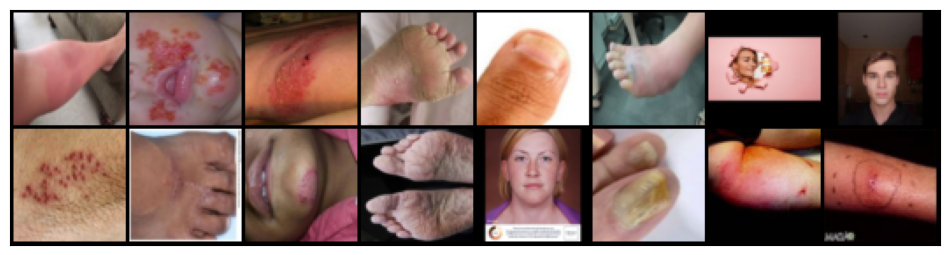

In [ ]:
show_batch(train_dl)

In [ ]:
import torchvision.datasets as datasets

In [ ]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
device=get_default_device()
device

device(type='cuda')

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


SE-Net

In [ ]:
input_size=64*64
num_classes=9

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
from torch import nn
class SE(nn.Module):
    def __init__(self, channel, reduction_ratio =16):
        super(SE, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.mlp = nn.Sequential(
            nn.Linear(channel, channel // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction_ratio, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.gap(x).view(b, c)
        y = self.mlp(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
import torch.nn as nn

class CNNWithSE(ImageClassificationBase):
    def __init__(self, num_classes=8):
        super(CNNWithSE, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SE(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SE(128),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SE(256),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SE(512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
import torch.optim as optim
model = CNNWithSE(9)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
model = model.to(device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
model=CNNWithSE(9)
to_device(model,device)

CNNWithSE(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): SE(
      (gap): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=False)
        (3): Sigmoid()
      )
    )
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): SE(
      (gap): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=False)
        (3): Sigmoid()
      )
    )
    (8): Conv2d(128, 256,

Training

In [ ]:
epochs=40
opt_func=torch.optim.Adam
lr=0.0001

In [ ]:
history = fit(125,lr,model,train_dl,val_dl,opt_func)

Epoch [0], train_loss: 2.1314, val_loss: 2.0883, val_acc: 0.1398
Epoch [1], train_loss: 1.9965, val_loss: 1.9260, val_acc: 0.2449
Epoch [2], train_loss: 1.9060, val_loss: 1.9159, val_acc: 0.2364
Epoch [3], train_loss: 1.8435, val_loss: 1.8382, val_acc: 0.2358
Epoch [4], train_loss: 1.8073, val_loss: 1.7843, val_acc: 0.2795
Epoch [5], train_loss: 1.8052, val_loss: 1.8007, val_acc: 0.2761
Epoch [6], train_loss: 1.7864, val_loss: 1.7513, val_acc: 0.2949
Epoch [7], train_loss: 1.7594, val_loss: 1.7822, val_acc: 0.2386
Epoch [8], train_loss: 1.7111, val_loss: 1.7032, val_acc: 0.3688
Epoch [9], train_loss: 1.6901, val_loss: 1.7353, val_acc: 0.3528
Epoch [10], train_loss: 1.6566, val_loss: 1.6431, val_acc: 0.3722
Epoch [11], train_loss: 1.6357, val_loss: 1.6118, val_acc: 0.4210
Epoch [12], train_loss: 1.6100, val_loss: 1.6215, val_acc: 0.4057
Epoch [13], train_loss: 1.5834, val_loss: 1.6036, val_acc: 0.3818
Epoch [14], train_loss: 1.5556, val_loss: 1.5731, val_acc: 0.3818
Epoch [15], train_lo

In [ ]:
history = fit(25,lr,model,train_dl,val_dl,opt_func)

Epoch [0], train_loss: 0.0484, val_loss: 1.9951, val_acc: 0.7455
Epoch [1], train_loss: 0.0665, val_loss: 1.6785, val_acc: 0.7983
Epoch [2], train_loss: 0.0183, val_loss: 1.6966, val_acc: 0.7830
Epoch [3], train_loss: 0.0033, val_loss: 1.4512, val_acc: 0.8199
Epoch [4], train_loss: 0.0009, val_loss: 1.6033, val_acc: 0.8136
Epoch [5], train_loss: 0.0004, val_loss: 1.5578, val_acc: 0.8136
Epoch [6], train_loss: 0.0004, val_loss: 1.5644, val_acc: 0.8074
Epoch [7], train_loss: 0.0004, val_loss: 1.5942, val_acc: 0.8011
Epoch [8], train_loss: 0.0003, val_loss: 1.5520, val_acc: 0.8199
Epoch [9], train_loss: 0.0003, val_loss: 1.5721, val_acc: 0.8011
Epoch [10], train_loss: 0.0003, val_loss: 1.5726, val_acc: 0.8011
Epoch [11], train_loss: 0.0003, val_loss: 1.5904, val_acc: 0.7949
Epoch [12], train_loss: 0.0003, val_loss: 1.5574, val_acc: 0.8011
Epoch [13], train_loss: 0.0003, val_loss: 1.6161, val_acc: 0.8074
Epoch [14], train_loss: 0.0002, val_loss: 1.5730, val_acc: 0.8136
Epoch [15], train_lo

In [ ]:
import pickle


with open('/content/drive/MyDrive/model_state-f2.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)

# Load model state
with open('/content/drive/MyDrive/model_state-f2.pkl', 'rb') as f:
    model.load_state_dict(pickle.load(f))


In [ ]:
import torch
torch.save(model.state_dict(), 'model_state.pth')

----

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

Testing

In [ ]:
test_dataset = ImageFolder('/content/drive/MyDrive/skin-disease-datasaet/test_set', transform=train_tfms)

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [ ]:
import matplotlib.pyplot as plt

Label: FU-nail-fungus , Predicted: FU-nail-fungus


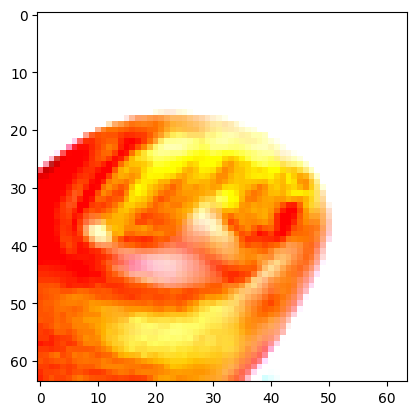

In [ ]:
img,label=test_dataset[90]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.5018893480300903, 'val_acc': 0.7796052694320679}

----------------
# ***Cells TO run***

In [ ]:
train_dir="/content/drive/MyDrive/skin-disease-dataset/test_set"

In [ ]:
import torchvision.transforms as T
stats=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_tfms=T.Compose([T.Resize((64,64)),
                      T.RandomHorizontalFlip(),
                      T.ToTensor(),
                      T.Normalize(*stats,inplace=True)
                       ])

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

dataset=ImageFolder(train_dir,transform=train_tfms)
len(dataset)

293

In [ ]:
classes=os.listdir(train_dir)
dataset.classes

['BA- cellulitis',
 'BA-impetigo',
 'FU-athlete-foot',
 'FU-nail-fungus',
 'FU-ringworm',
 'PA-cutaneous-larva-migrans',
 'VI-chickenpox',
 'VI-shingles',
 'normal']

In [ ]:
import torch
from torch.utils.data import random_split
val_size= 150
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(143, 150)

In [ ]:
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [ ]:
import torch.nn as nn
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [ ]:
import torchvision.datasets as datasets
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device=get_default_device()
device

device(type='cuda')

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

NameError: name 'train_dl' is not defined

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
input_size=64*64
num_classes=9
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
from torch import nn
class SE(nn.Module):
    def __init__(self, channel, reduction_ratio =16):
        super(SE, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.mlp = nn.Sequential(
            nn.Linear(channel, channel // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction_ratio, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.gap(x).view(b, c)
        y = self.mlp(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
import torch.optim as optim

class CNNWithSE(ImageClassificationBase):
    def __init__(self, num_classes=8):
        super(CNNWithSE, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SE(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SE(128),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SE(256),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SE(512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
model = CNNWithSE(9)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
import pickle
with open('/content/drive/MyDrive/model_state-f2.pkl', 'rb') as f:
    model.load_state_dict(pickle.load(f))

In [ ]:
test_dataset = ImageFolder('/content/drive/MyDrive/skin-disease-dataset/test_set', transform=train_tfms)

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [ ]:
to_device(model,device)

CNNWithSE(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): SE(
      (gap): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=False)
        (3): Sigmoid()
      )
    )
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): SE(
      (gap): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=False)
        (3): Sigmoid()
      )
    )
    (8): Conv2d(128, 256,

Label: FU-nail-fungus , Predicted: FU-nail-fungus


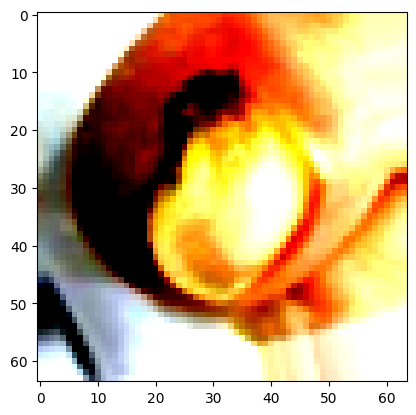

In [ ]:
import matplotlib.pyplot as plt
img,label=test_dataset[110]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
batch_size = 64
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.465981364250183, 'val_acc': 0.7837837934494019}

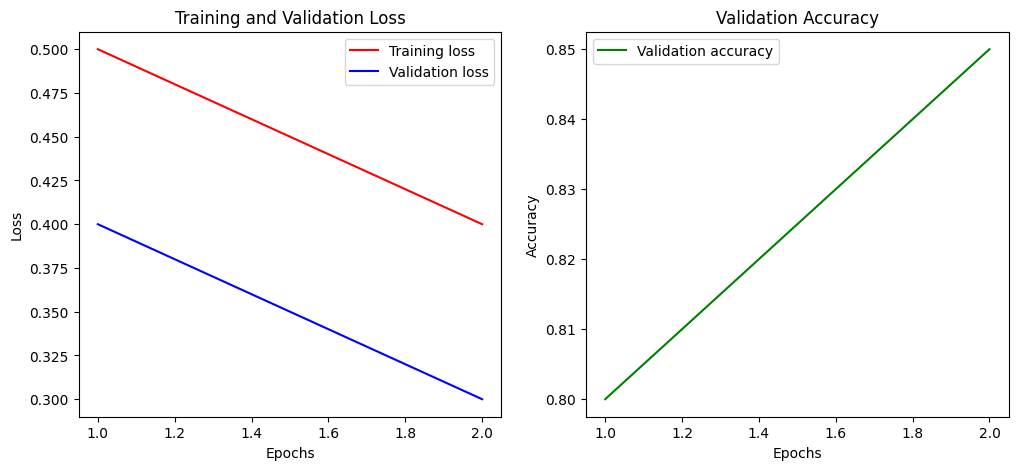

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss graphs
def plot_metrics(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    val_accs = [x['val_acc'] for x in history]

    epochs = range(1, len(history) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accs, 'g', label='Validation accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Example: Replace this with your actual training history
history = [
    {'train_loss': 0.5, 'val_loss': 0.4, 'val_acc': 0.8},
    {'train_loss': 0.4, 'val_loss': 0.3, 'val_acc': 0.85},
    # ... add more epochs as needed
]

# Assuming `history` contains the training history
plot_metrics(history)